In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from time import time
from astropy import units as u

In [2]:
import ducc0
from time import time
import multiprocessing
nthreads = multiprocessing.cpu_count()

## Objective

We compare the transform from spherical harmonics space to pixel space and back using HEALPix and Gauss-Legendre pixelization.
The context is the evaluation of sky emission models for PySM, we have an input power law with simulated small-scales, we need
to transform to pixel space to evaluate the model (multiply maps, take exponents), then back to spherical harmonics to smooth the
map and back to the output map.

Output a model at $N_{side}=2048$ with a $\ell_{max} = 3 N_{side} -1$.
Using HEALPix, we need to do modelling at higher $N_{side}$ to avoid integration issues in `map2alm` between $\ell=2 N_{side}$ and $\ell=3 N_{side}$.

So we evaluate the models at $N_{side}=4096$ with $\ell_{max} = 2 N_{side} -1$.

In [3]:
target_nside = 2048
target_lmax = 3 * target_nside - 1

In [4]:
modelling_nside = 4096
modelling_lmax = 2* modelling_nside

## Input model

We assume as input a Intensity only power-law:

$ A \ell ^ \gamma $

In [5]:
def power_law(ell, amplitude, gamma):
    np.seterr(divide = 'ignore') 
    out = amplitude * ell ** gamma
    out[:1] = 0
    return out

with parameters:

In [6]:
gamma = -1
amplitude = 1

In [7]:
ell = np.arange(modelling_lmax + 1, dtype=np.float32)
ell_norm = ell * (ell + 1) / (2*np.pi)
ell_norm[0] = 1

In [8]:
input_power_law = power_law(ell, amplitude, gamma)
input_power_spectrum = input_power_law / ell_norm

and we create a realization of this spectrum:

In [9]:
np.random.seed(8888)
alm = hp.synalm(input_power_spectrum)

## HEALPix alm -> map -> alm

In PySM we can probably skip this first step and directly provide maps at all resolutions precomputed.

In [10]:
timings = {}

In [11]:
t0=time()
healpix_map = hp.alm2map(alm, nside=modelling_nside)
timings["H_alm2map"] = round(time()-t0)
print(f"Alm2map, nside {modelling_nside}, lmax {modelling_lmax}")

Alm2map, nside 4096, lmax 8192


Once we are in pixel space, we can evaluate the model, generally multiplying multiple maps.
Then we need to transform back to spherical harmonics space to apply the instrument beam window function,
we only need to go to $1.5 N_{side}$ when we transform back, so we safely use pixel weights:

In [12]:
t0 = time()
alm_from_m = hp.map2alm(healpix_map, use_pixel_weights=True, lmax=target_lmax)
timings["H_map2alm"] = round(time()-t0)
print(f"Map2alm, lmax {target_lmax}")
cl_from_m = hp.alm2cl(alm_from_m)

Map2alm, lmax 6143


## Gauss-Legendre alm -> map -> alm

We can do the equivalent with Gauss-Legendre pixelization:

In [13]:
modelling2target_lmax = []
lclip = target_lmax
for m in range(lclip+1):
    modelling2target_lmax.append(hp.Alm.getidx(modelling_lmax, np.arange(m, lclip+1), m))
modelling2target_lmax = np.concatenate(modelling2target_lmax)

In [14]:
alm_target = alm[modelling2target_lmax]

In [15]:
# set maximum multipole moment
lmax = target_lmax
# maximum m.
mmax = lmax

# Number of pixels per ring. Must be >=2*lmax+1, but I'm choosing a larger
# number for which the FFT is faster.
nlon = 2*lmax+2

# create a set of spherical harmonic coefficients to transform
# Libsharp works exclusively on real-valued maps. The corresponding harmonic
# coefficients are termed a_lm; they are complex numbers with 0<=m<=lmax and
# m<=l<=lmax.
# Symmetry: a_l,-m = (-1)**m*conj(a_l,m).
# The symmetry implies that all coefficients with m==0 are purely real-valued.
# The a_lm are stored in a 1D complex-valued array, in the following order:
# a_(0,0), a(1,0), ..., a_(lmax,0), a(1,1), a(2,1), ... a(lmax,1), ..., a(lmax, mmax)

# number of required a_lm coefficients
nalm = ((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax)
# get random a_lm
rng = np.random.default_rng(42)
#alm = rng.uniform(-1., 1., nalm) + 1j*rng.uniform(-1., 1., nalm)
# make a_lm with m==0 real-valued
alm_target[0:target_lmax+1].imag = 0.
# add an extra leading dimension to the a_lm. This is necessary since for
# transforms with spin!=0 two a_lm sets are required instead of one.
alm_target = alm_target.reshape((1,-1))

print("testing Gauss-Legendre grid with lmax+1 rings")

# Number of iso-latitude rings required for Gauss-Legendre grid
nlat = lmax+1

# go from a_lm to map
t0 = time()
GL_map = ducc0.sht.experimental.synthesis_2d(
    alm=alm_target, ntheta=nlat, nphi=nlon, lmax=lmax, mmax=mmax, spin=0,
    geometry="GL", nthreads=nthreads)
timings["GL_alm2map"] = round(time()-t0)
print("time for map synthesis: {}s".format(timings["GL_alm2map"]))

# transform back to a_lm

t0 = time()
alm2 = ducc0.sht.experimental.analysis_2d(
    map=GL_map, lmax=lmax, mmax=mmax, spin=0, geometry="GL", nthreads=nthreads)
timings["GL_map2alm"] = round(time()-t0)
print("time for map analysis: {}s".format(timings["GL_map2alm"]))

testing Gauss-Legendre grid with lmax+1 rings
time for map synthesis: 6s
time for map analysis: 6s


A Gauss-Legendre map is a 2D array where each row is a equilatitude ring,
we can also project it to Mollweide with `matplotlib`:

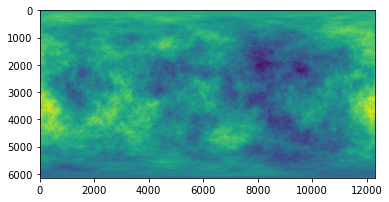

In [16]:
plt.imshow(GL_map[0]);

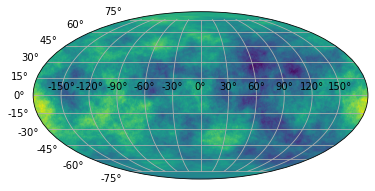

In [17]:
ax = plt.axes(projection='mollweide')
ax.grid()
ax.imshow(GL_map[0], extent=[0, 1, 0, 1], aspect=ax.get_aspect(), transform=ax.transAxes);

0.0 180.0 -180.0 180.0


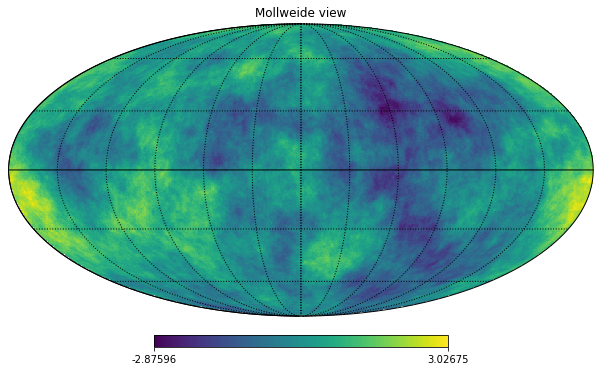

In [18]:
# projection conventions are different from healpy
hp.mollview(healpix_map, rot=[-180], flip="geo")
hp.graticule()

In [19]:
cl_GL = hp.alm2cl(alm2)

## Compare the 2 approaches

We want to compute errors just until the target $N_{side}$:

In [20]:
L2_GL = ducc0.misc.l2error(alm_target[0, 1:], alm2[0, 1:])
L2_healpix = ducc0.misc.l2error(alm_target[0, 1:], alm_from_m[1:])

In [21]:
target_ell = np.arange(target_lmax + 1)
target_ell_norm = target_ell * (target_ell + 1) / (2*np.pi)
target_ell_norm[0] = 1

We can compare the output spectra and the error,
the output power spectra are the same within machine precision,
but the $a_{\ell m}$ are not:

No handles with labels found to put in legend.


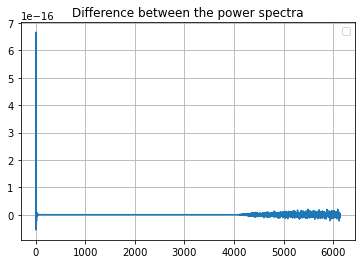

In [22]:
plt.plot(cl_GL[0]  - cl_from_m)
plt.legend()
plt.grid()
plt.title("Difference between the power spectra");

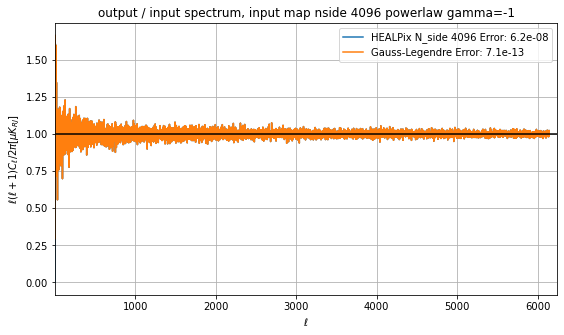

In [23]:
plt.figure(figsize=(9, 5))

cl = cl_from_m*target_ell_norm/input_power_law[:len(target_ell)]
cl[0] = 0
std = cl.std()
plt.axvline(np.pi/hp.nside2resol(target_nside), color="gray")

plt.plot(target_ell, cl, label=f"HEALPix N_side {modelling_nside} Error: {L2_healpix:.2g}")
plt.plot(target_ell, cl_GL[0] * target_ell_norm / input_power_law[:len(target_ell)], label=f"Gauss-Legendre Error: {L2_GL:.2g}")

plt.legend()
plt.grid()
plt.title(f"output / input spectrum, input map nside {modelling_nside} powerlaw gamma={gamma}")
plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))
plt.axhline(1, color="black")
plt.savefig(f"spec_ratio_HEALPix_GL.png")
plt.xlim(1, target_lmax+100);

### Time necessary for the transforms

In seconds

In [24]:
timings

{'H_alm2map': 34, 'H_map2alm': 23, 'GL_alm2map': 6, 'GL_map2alm': 6}

### Memory usage in pixel space

Size of temperature-only maps with the requested $\ell_{max}$ for GL and $N_{side}$ for HEALPix

In [25]:
(GL_map.nbytes * u.byte).to(u.GB)

<Quantity 0.60397978 Gbyte>

In [26]:
(healpix_map.nbytes * u.byte).to(u.GB)

<Quantity 1.61061274 Gbyte>